# **Bank Product Subscription Prediction**

## **1. Introduction**

### **1.1 Problem description:**
We aim to predict customer responses in the bank marketing dataset, where the target variable indicates whether a client subscribed to a product.

### **1.2 Objective:**
Build a machine learning pipeline using feature engineering, LightGBM leaf encoding, and logistic regression, optimized with Optuna, to achieve strong predictive performance.

## 2. **Imports and Configuration**

In [37]:
# -----------------------------
# Numerical & data handling
# -----------------------------
import numpy as np
import pandas as pd

# -----------------------------
# Plotting
# -----------------------------
import matplotlib.pyplot as plt

# -----------------------------
# Third-party utilities
# -----------------------------
import cloudpickle
import optuna
import sqlite3
from optuna.samplers import TPESampler
from scipy.stats import randint

# -----------------------------
# Scikit-learn
# -----------------------------
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted

# -----------------------------
# External models
# -----------------------------
from lightgbm import LGBMClassifier

# -----------------------------
# Reproducibility
# -----------------------------
RANDOM_STATE = 42
CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
SCORING = "roc_auc"

# -----------------------------
# Data paths
# -----------------------------
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SUBMISSION_PATH = "submission.csv"

# Silence common warnings
import warnings
warnings.filterwarnings("ignore")

## 2. **Dataset Description**

##### **Data Dictionary**
- **age** *(int)*: Client age (years).  
- **job** *(category)*: Type of job (e.g., admin., technician, services, management, student, retired).  
- **marital** *(category)*: Marital status (single, married, divorced).  
- **education** *(category)*: Education level (primary, secondary, tertiary, unknown).  
- **default** *(category)*: Has credit in default? (yes/no/unknown).  
- **balance** *(int)*: Average yearly balance in euros.  
- **housing** *(category)*: Has a housing loan? (yes/no/unknown).  
- **loan** *(category)*: Has a personal loan? (yes/no/unknown).  
- **contact** *(category)*: Contact communication type (cellular/telephone/unknown).  
- **day** *(int)*: Last contact day of the month (1–31).  
- **month** *(category)*: Last contact month (jan–dec).  
- **duration** *(int)*: Last contact duration, in seconds.  
- **campaign** *(int)*: Number of contacts performed during this campaign for this client.  
- **pdays** *(int)*: Days passed since the client was last contacted from a previous campaign (−1 means never).  
- **previous** *(int)*: Number of contacts performed before this campaign.  
- **poutcome** *(category)*: Outcome of the previous marketing campaign (success/failure/other/unknown).  
- **y** *(binary target)*: Has the client subscribed to a term deposit? (1=yes, 0=no).

In [25]:
# -----------------------------
# Step 1: Load datasets
# -----------------------------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# -----------------------------
# Step 2: Preserve test IDs for submission
# -----------------------------
test_ids = (
    test["id"].copy()
    if "id" in test.columns
    else pd.Series(np.arange(len(test)), name="id")
)

# -----------------------------
# Step 3: Remove "id" column from train/test (if present)
# -----------------------------
if "id" in train.columns:
    train = train.drop(columns=["id"])
if "id" in test.columns:
    test = test.drop(columns=["id"])

# -----------------------------
# Step 4: Split features/target from train
# -----------------------------
if "y" not in train.columns:
    raise ValueError('Target column "y" was not found in the training data.')

X = train.drop(columns=["y"])
y = train["y"]

# -----------------------------
# Step 5: Basic overview
# -----------------------------
print(f"train shape: {train.shape} | test shape: {test.shape}")

print("\nQuick view of feature columns (name & dtype):")
try:
    print(pd.DataFrame({"col": X.columns, "dtype": X.dtypes.astype(str).values}).head(20))
except NameError:
    print(pd.DataFrame({"col": X.columns, "dtype": X.dtypes.astype(str).values}).head(20))

print("\nTarget balance (proportions):")
print(y.value_counts(normalize=True).rename("proportion"))

# -----------------------------
# Step 6: Preview training data (without target column)
# -----------------------------
print("\n=== Data preview (first 5 rows, features only) ===")
print(X.head(5))

# -----------------------------
# Step 7: Data types, missing values, and 'unknown' placeholders
# -----------------------------
print("\n=== Data types, missing counts, and 'unknown' placeholders (features) ===")
def count_unknowns(series: pd.Series) -> int:
    if series.dtype == "object":
        return (series.astype(str).str.lower() == "unknown").sum()
    return 0

info_df = pd.DataFrame({
    "dtype": X.dtypes,
    "null": X.isnull().sum(),
    "unknown": X.apply(count_unknowns)
}).sort_values(by="unknown", ascending=False)

print(info_df)

# -----------------------------
# Step 8: Descriptive statistics for numerical features
# -----------------------------
print("\n=== Descriptive statistics (numerical features) ===")
num_cols = X.select_dtypes(include=["number"])
if num_cols.shape[1] > 0:
    print(num_cols.describe())
else:
    print("No numerical features detected.")

# -----------------------------
# Step 9: Categorical features — cardinality and sample categories
# -----------------------------
print("\n=== Categorical features: unique counts & sample values ===")
cat_cols = X.select_dtypes(include="object")
if cat_cols.shape[1] > 0:
    unique_summary = pd.DataFrame({
        "Unique Count": cat_cols.nunique(),
        "Sample Values": cat_cols.apply(lambda s: s.dropna().astype(str).unique()[:10])
    })
    print(unique_summary)
else:
    print("No categorical features detected.")

# -----------------------------
# Step 10: Duplicate row check (full training rows including target)
# -----------------------------
duplicates = train.duplicated().sum()
print("\n=== Duplicate rows in training data ===")
print(f"Number of duplicate rows: {duplicates}")

train shape: (750000, 17) | test shape: (250000, 16)

Quick view of feature columns (name & dtype):
          col   dtype
0         age   int64
1         job  object
2     marital  object
3   education  object
4     default  object
5     balance   int64
6     housing  object
7        loan  object
8     contact  object
9         day   int64
10      month  object
11   duration   int64
12   campaign   int64
13      pdays   int64
14   previous   int64
15   poutcome  object

Target balance (proportions):
y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

=== Data preview (first 5 rows, features only) ===
   age          job  marital  education default  balance housing loan  \
0   42   technician  married  secondary      no        7      no   no   
1   38  blue-collar  married  secondary      no      514      no   no   
2   36  blue-collar  married  secondary      no      602     yes   no   
3   27      student   single  secondary      no       34     yes   no   
4   26   techni

## 3. **Feature Engineering**

The goal of this transformer is to prepare raw **bank marketing campaign data** for machine learning models.  

In [27]:
class FE(BaseEstimator, TransformerMixin):
    """
    Feature engineering for the bank marketing dataset (LightGBM-ready).
    """
    def __init__(self, drop_duration: bool = True, month_order=None):
        self.drop_duration = drop_duration
        self.month_order = month_order or ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]

    # ---------- fit ----------
    def fit(self, X, y=None):
        return self

    # ---------- transform ----------
    def transform(self, X):
        X = X.copy()

        # ---- Define original candidates according to dataset schema ----
        num_orig = [c for c in ["age","balance","day","duration","campaign","pdays","previous"] if c in X.columns]
        cat_orig = [c for c in ["job","marital","education","default","housing","loan","contact","poutcome","month"] if c in X.columns]

        # Numeric → float
        if num_orig:
            X[num_orig] = X[num_orig].apply(pd.to_numeric, errors="coerce").astype(float)

        # Categoricals → normalize text and cast to category
        if cat_orig:
            X[cat_orig] = X[cat_orig].astype("string")
            X[cat_orig] = X[cat_orig].apply(lambda s: s.str.strip().str.lower())
            X[cat_orig] = X[cat_orig].replace("unknown", pd.NA)

            if "month" in cat_orig:
                vals = set(X["month"].dropna().unique())
                if vals.issubset(set(self.month_order)):
                    X["month"] = pd.Categorical(X["month"], categories=self.month_order, ordered=True)
                else:
                    X["month"] = X["month"].astype("category")

            others = [c for c in cat_orig if c != "month"]
            if others:
                X[others] = X[others].astype("category")

        # ---- Aggregated unknowns ----
        unk_pool = [c for c in ["job","education","contact","poutcome","default","housing","loan","month"] if c in X.columns]
        if unk_pool:
            X["unknowns_count"] = X[unk_pool].isna().sum(axis=1).astype(float)

        # ---- Contact signals ----
        if "pdays" in X.columns:
            X["pdays_recency"] = np.where(X["pdays"] >= 0, 1.0 / (X["pdays"] + 1.0), 0.0).astype(float)
            if "previous" in X.columns:
                is_first = ((X["pdays"] == -1) & (X["previous"].fillna(0) == 0)).astype("int8")
                X["is_first_contact"] = pd.Categorical(is_first, categories=[0,1])
                
        if "campaign" in X.columns:
            X["campaign_log1p"] = np.log1p(X["campaign"].clip(lower=0)).astype(float)
            
        if "previous" in X.columns:
            X["previous_log1p"] = np.log1p(X["previous"].clip(lower=0)).astype(float)
            
        if {"campaign_log1p","previous_log1p"}.issubset(X.columns):
            X["contact_intensity_log"] = (X["campaign_log1p"] - X["previous_log1p"]).astype(float)

        # ---- Previous campaign outcome ----
        if "poutcome" in X.columns:
            pout_succ = (X["poutcome"] == "success").fillna(False).astype("int8")
            X["poutcome_success"] = pd.Categorical(pout_succ, categories=[0,1])

        # ---- Economic capacity/risk ----
        if "balance" in X.columns:
            X["balance_logsign"] = (np.sign(X["balance"]) * np.log1p(np.abs(X["balance"]))).astype(float)

        if {"housing","loan"}.issubset(X.columns):
            X["total_loans"] = ((X["housing"] == "yes").astype("int8") + (X["loan"] == "yes").astype("int8")).astype(float)

        cols = [c for c in ["default","housing","loan"] if c in X.columns]
        if cols:
            X["financial_stress"] = (X[cols] == "yes").astype(int).sum(axis=1).astype(float)

        # ---- Drop duration ----
        if self.drop_duration and "duration" in X.columns:
            X = X.drop(columns=["duration"])

        return X

## 4. **Modeling**

In this step, we build a full modeling pipeline.  
First, we define a custom transformer (`LeafOneHotEncoder`) that converts GBDT leaf indices into one-hot features.  
Then we set up a LightGBM base model, apply feature engineering and leaf encoding, and finally train a Logistic Regression classifier on top.  

In [33]:
class LeafOneHotEncoder(BaseEstimator, TransformerMixin):
    """
    Fit a LightGBM model, obtains the leaf index for each sample and tree,
    and then fits a OneHotEncoder on those leaf indices.
    """

    def __init__(self, lgbm_estimator, onehot_kwargs=None):
        self.lgbm_estimator = lgbm_estimator
        self.onehot_kwargs = onehot_kwargs or {}

    def fit(self, X, y):
        # Clone to avoid mutating the original estimator instance
        self.model_ = clone(self.lgbm_estimator)
        self.model_.fit(X, y)
        # Compute leaf indices for the training data
        leaves = self._leafs(X)
        # Fit the OneHotEncoder on the categorical leaf indices
        self.ohe_ = OneHotEncoder(handle_unknown="ignore", **self.onehot_kwargs)
        self.ohe_.fit(leaves)
        return self

    def transform(self, X):
        check_is_fitted(self, ("model_", "ohe_"))
        # Get leaf indices for X with the already-fitted LightGBM
        leaves = self._leafs(X)
        # One-hot encode the leaf indices (sparse or dense per onehot_kwargs)
        return self.ohe_.transform(leaves)

    # ------- helper -------
    def _leafs(self, X):
        # LightGBM-specific: predict with pred_leaf=True yields leaf indices
        leaves = self.model_.predict(X, pred_leaf=True)
        leaves = np.asarray(leaves)
        # Ensure 2D shape (n_samples, n_trees)
        if leaves.ndim == 1:
            leaves = leaves.reshape(-1, 1)
        return leaves

fe = FE(drop_duration=False)

# -----------------------------
# Step 1: Base GBDT model
# -----------------------------
lgbm_base = LGBMClassifier(
    n_estimators=180,
    num_leaves=31,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_samples=60,
    max_depth=-1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

# -----------------------------
# Step 2: Leaf-index one-hot pipeline
# (Feature engineering -> leaf indices -> one-hot)
# -----------------------------
leaf_encoder = Pipeline(steps=[
    ("fe", fe),
    ("leaf_ohe", LeafOneHotEncoder(
        lgbm_estimator=lgbm_base,
        onehot_kwargs={"sparse_output": True}
    )),
])

# -----------------------------
# Step 3: Downstream classifier
# -----------------------------
logreg = LogisticRegression(
    penalty="l2",
    C=0.3,
    solver="saga",
    max_iter=1000,
    n_jobs=-1,
)

# -----------------------------
# Step 4: Full modeling pipeline
# -----------------------------
GBDTLeafLogReg = Pipeline(steps=[
    ("leaf_features", leaf_encoder),
    ("lr", logreg),
])

# -----------------------------
# Step 5: Train/validation split
# -----------------------------
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(f"Shapes -> X_tr: {X_tr.shape} | X_va: {X_va.shape}")

Shapes -> X_tr: (600000, 16) | X_va: (150000, 16)


## 5. **Hyperparameter Tuning with Optuna**

At this stage, we focus on **improving model performance** by carefully searching for the best hyperparameters.  
We define a search space for key parameters of both the **GBDT estimator** and the **logistic regression classifier**, such as:

- Number of boosting iterations (`n_estimators`)
- Learning rate (`learning_rate`)
- Tree structure parameters (`num_leaves`, `min_child_samples`)
- Sampling strategies (`subsample`, `colsample_bytree`)
- Regularization strength for logistic regression (`C`)

We use **Optuna** to explore this space and maximize cross-validation performance.  
After the search, we select the **best trial**, retrain the model with these optimized parameters, and finally save the trained model for later use.

In [ ]:
# -----------------------------
# Step 1: Define the objective (search space + CV metric)
# -----------------------------
def objective(trial):
    # Hyperparameter search space
    params = {
        "leaf_features__leaf_ohe__lgbm_estimator__n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "leaf_features__leaf_ohe__lgbm_estimator__num_leaves":   trial.suggest_int("num_leaves", 15, 255),
        "leaf_features__leaf_ohe__lgbm_estimator__learning_rate":trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "leaf_features__leaf_ohe__lgbm_estimator__min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "leaf_features__leaf_ohe__lgbm_estimator__subsample":    trial.suggest_float("subsample", 0.5, 1.0),
        "leaf_features__leaf_ohe__lgbm_estimator__colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lr__C": trial.suggest_float("lr_C", 1e-3, 1e+2, log=True),
    }
    # Clone the pipeline to avoid mutating the original object
    model = clone(GBDTLeafLogReg).set_params(**params)
    # Cross-validated score to maximize
    scores = cross_val_score(model, X_tr, y_tr, scoring=SCORING, cv=CV, n_jobs=-1)
    return scores.mean()


# -----------------------------
# Step 2: Create the study (sampler + baseline enqueue)
# -----------------------------
sampler = TPESampler(seed=RANDOM_STATE, multivariate=True, n_startup_trials=5)
study = optuna.create_study(
    study_name="lgbm_logreg_opt",
    direction="maximize",
    sampler=sampler,
    storage="sqlite:///optuna_study.db",
    load_if_exists=True,
)
# Reasonable baseline so early trials aren't wasted
study.enqueue_trial({
    "n_estimators": 180, "num_leaves": 31, "learning_rate": 0.05,
    "min_child_samples": 60, "subsample": 0.8, "colsample_bytree": 0.8, "lr_C": 0.3
})

# -----------------------------
# Step 3: Run optimization
# -----------------------------
study.optimize(objective, n_trials=12, timeout=None, n_jobs=1, gc_after_trial=True)
print(">> Best params (Optuna):", study.best_trial.params)
print(f">> Best CV score ({SCORING}): {study.best_value:.4f}")

# -----------------------------
# Step 4: Retrain the final model with the best hyperparameters
# ----------------------------
# We map them back to the pipeline's parameter keys.
best_params = {
    "leaf_features__leaf_ohe__lgbm_estimator__n_estimators": study.best_trial.params["n_estimators"],
    "leaf_features__leaf_ohe__lgbm_estimator__num_leaves":   study.best_trial.params["num_leaves"],
    "leaf_features__leaf_ohe__lgbm_estimator__learning_rate":study.best_trial.params["learning_rate"],
    "leaf_features__leaf_ohe__lgbm_estimator__min_child_samples": study.best_trial.params["min_child_samples"],
    "leaf_features__leaf_ohe__lgbm_estimator__subsample":    study.best_trial.params["subsample"],
    "leaf_features__leaf_ohe__lgbm_estimator__colsample_bytree": study.best_trial.params["colsample_bytree"],
    "lr__C": study.best_trial.params["lr_C"],
}
best_model = clone(GBDTLeafLogReg).set_params(**best_params)
best_model.fit(X_tr, y_tr)

# -----------------------------
# Step 5: Persist the trained model to disk
# -----------------------------
with open("model.pkl", "wb") as f:
    cloudpickle.dump(best_model, f)

## **6. Model Evaluation**

In this section, we load the trained model and evaluate its performance on the validation set.  
We calculate key metrics such as ROC AUC, Average Precision (AP), and the baseline positive rate.  
Additionally, we generate a classification report, confusion matrix, and visualize the ROC and Precision–Recall curves.

Validation ROC AUC:  0.96779
Validation AP:       0.80897
Baseline (pos rate): 0.12065

Classification report (threshold = 0.5)
              precision    recall  f1-score   support

           0     0.9570    0.9709    0.9639    131902
           1     0.7628    0.6822    0.7202     18098

    accuracy                         0.9361    150000
   macro avg     0.8599    0.8265    0.8421    150000
weighted avg     0.9336    0.9361    0.9345    150000

Confusion matrix (rows=true, cols=pred):
[[128063   3839]
 [  5752  12346]]


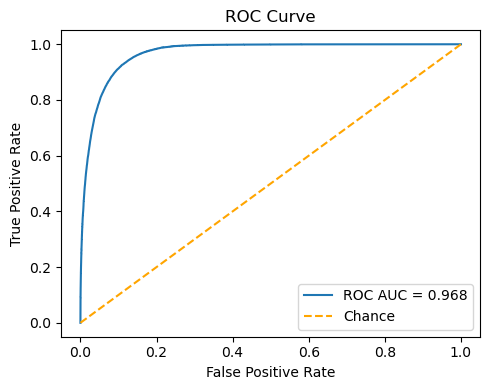

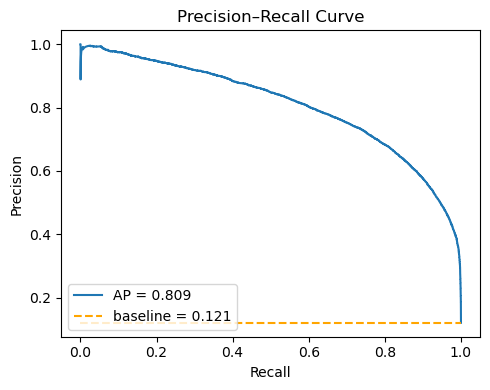

In [127]:
# -----------------------------
# Step 1: Load the trained model
# -----------------------------
# Load model
with open("model.pkl", "rb") as f:
    model = cloudpickle.load(f)

# -----------------------------
# Step 2: Get validation scores and a default 0.5 threshold prediction
# -----------------------------
va_scores = model.predict_proba(X_va)[:, 1]
va_pred = (va_scores >= 0.5).astype(int)

# -----------------------------
# Step 3: Core metrics
# -----------------------------
rocauc   = roc_auc_score(y_va, va_scores)
ap       = average_precision_score(y_va, va_scores)
baseline = np.mean(y_va) 

print(f"Validation ROC AUC:  {rocauc:.5f}")
print(f"Validation AP:       {ap:.5f}")
print(f"Baseline (pos rate): {baseline:.5f}\n")

print("Classification report (threshold = 0.5)")
print(classification_report(y_va, va_pred, digits=4))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_va, va_pred))

# -----------------------------
# Step 4: Curves (ROC and Precision-Recall)
# -----------------------------
# ROC Curve
fpr, tpr, _ = roc_curve(y_va, va_scores)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {rocauc:.3f}")
plt.plot([0, 1], [0, 1], "--", label="Chance", color="orange")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_va, va_scores)
plt.figure(figsize=(5, 4))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.hlines(baseline, 0, 1, linestyles="--", label=f"baseline = {baseline:.3f}", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()